In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Paths
RAW = Path("../data/raw/exoplanets_raw.csv")
OUT = Path("../data/clean")
OUT.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(RAW)
print("Shape:", df.shape)
print(df.columns)
df.head()


Shape: (6031, 98)
Index(['name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_error_max', 'tzero_tr_sec', 'tzero_tr_sec_error_min',
       'tzero_tr_sec_error_max', 'lambda_angle', 'lambda_angle_error_min',
       'lambda_angle_error_max', 'impact_parameter',
       'impact_parameter

,name,planet_status,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,radius_error_min,...,star_sp_type,star_age,star_age_error_min,star_age_error_max,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names
0,109 Psc b,Confirmed,5.743,0.289,1.011,6.3830,0.078,0.078,1.152,NaN,...,G5 IV,6.90,0.60,0.60,5600.0,80.000,80.000,NaN,NaN,HD 10697
1,112 Psc b,Confirmed,NaN,0.005,0.004,0.0330,0.005,0.004,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
2,112 Psc c,Confirmed,9.866,1.781,3.190,NaN,NaN,NaN,NaN,NaN,...,G0IV,NaN,NaN,NaN,5986.0,105.437,105.437,NaN,NaN,HD 12235
3,11 UMi b,Confirmed,NaN,1.100,1.100,11.0873,1.100,1.100,NaN,NaN,...,K4III,1.56,0.54,0.54,4340.0,70.000,70.000,NaN,NaN,NaN
4,14 And Ab,Confirmed,NaN,0.230,0.230,4.6840,0.230,0.230,NaN,NaN,...,K0III,NaN,NaN,NaN,4813.0,20.000,20.000,NaN,NaN,NaN


In [4]:
# Normalize column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^a-z0-9]+", "_", regex=True)
)

# Pick relevant columns
df = df.rename(columns={
    'name': 'planet_name',
    'mass': 'mass',
    'radius': 'radius',
    'orbital_period': 'orbital_period',
    'semi_major_axis': 'semi_major_axis',
    'eccentricity': 'eccentricity',
    'star_teff': 'star_teff',
    'star_mass': 'star_mass',
    'star_radius': 'star_radius',
    'star_distance': 'distance_pc',
    
})


# Keep only needed columns
df = df[[
    'planet_name', 'mass', 'radius', 'orbital_period', 'semi_major_axis',
    'eccentricity', 'star_teff', 'star_mass', 'star_radius',
    'distance_pc',
]]
df.head()


,planet_name,mass,radius,orbital_period,semi_major_axis,eccentricity,star_teff,star_mass,star_radius,distance_pc
0,109 Psc b,5.743,1.152,1075.40,2.051,0.104,5600.0,1.13,1.790,32.5600
1,112 Psc b,NaN,NaN,4.40,0.054,0.376,5986.0,1.10,1.801,31.7627
2,112 Psc c,9.866,NaN,36336.70,22.210,0.174,5986.0,1.10,1.801,31.7627
3,11 UMi b,NaN,NaN,516.22,1.540,0.080,4340.0,1.80,24.080,119.5000
4,14 And Ab,NaN,NaN,185.84,0.830,0.000,4813.0,2.20,11.000,76.4000


In [5]:
def hz_bounds_temp(teff):
    s_eff = 0.00001 * teff ** 2  # proxy for flux received
    inner = 0.75 / np.sqrt(s_eff)
    outer = 1.77 / np.sqrt(s_eff)
    return inner, outer

inner, outer = hz_bounds_temp(df["star_teff"])
df["hz_inner_au"] = inner
df["hz_outer_au"] = outer

# Earth-sized planet
df = df[df["radius"].notnull()]
df["earth_sized"] = df["radius"].between(0.8, 1.5)

# Inside the habitable zone
df = df[df["semi_major_axis"].notna() & df["hz_inner_au"].notna()]

df["in_hz"] = (
    df["semi_major_axis"].notna() &
    df["hz_inner_au"].notna() &
    (df["semi_major_axis"] >= df["hz_inner_au"]) &
    (df["semi_major_axis"] <= df["hz_outer_au"])
)

# Final label
df["habitability_label"] = (df["earth_sized"] & df["in_hz"]).astype(int)
df[["planet_name", "radius", "semi_major_axis", "earth_sized", "in_hz", "habitability_label"]].head(40)
df["habitability_label"].value_counts()



habitability_label
0    2716
1     344
Name: count, dtype: int64

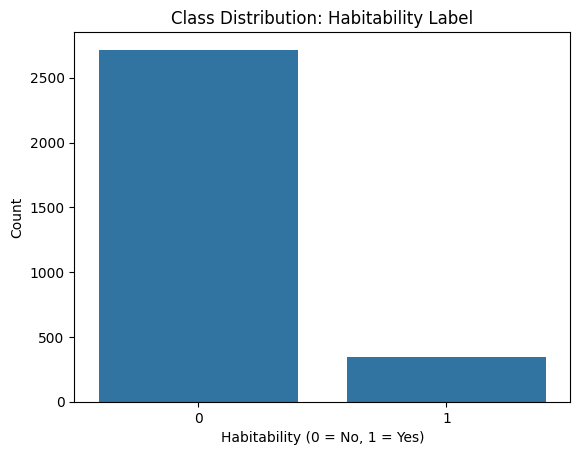

habitability_label
0    2716
1     344
Name: count, dtype: int64
habitability_label
0    0.887582
1    0.112418
Name: proportion, dtype: float64


In [6]:
sns.countplot(data=df, x='habitability_label')
plt.title("Class Distribution: Habitability Label")
plt.xlabel("Habitability (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Print exact counts
print(df["habitability_label"].value_counts())
print(df["habitability_label"].value_counts(normalize=True))

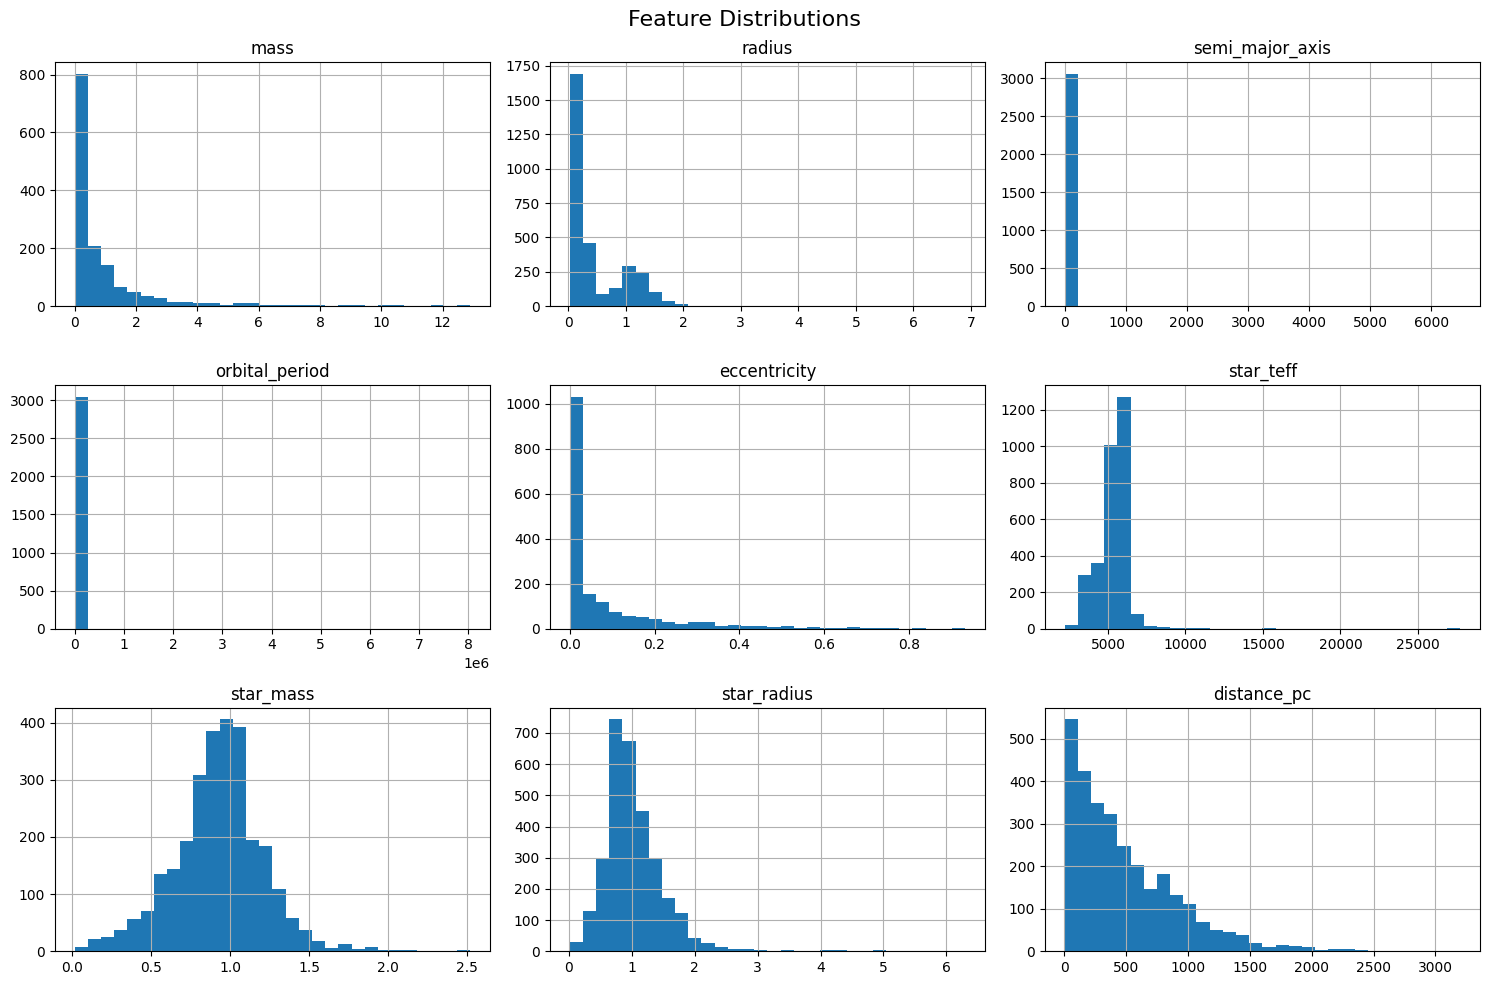

In [7]:
num_cols = ['mass', 'radius', 'semi_major_axis', 'orbital_period',
            'eccentricity', 'star_teff', 'star_mass', 'star_radius', 'distance_pc']

df[num_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

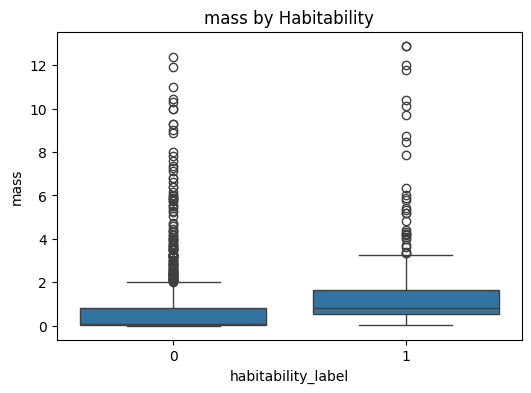

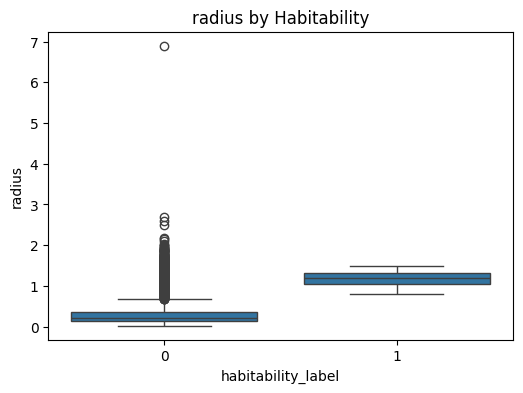

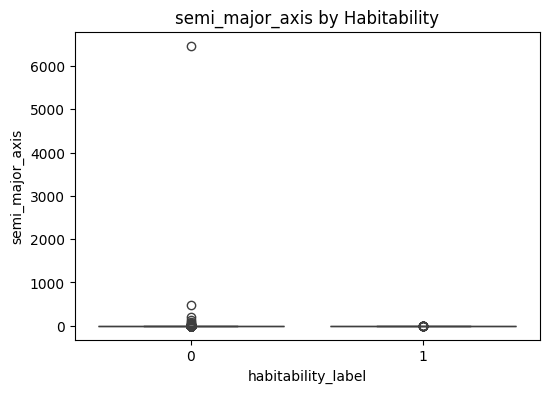

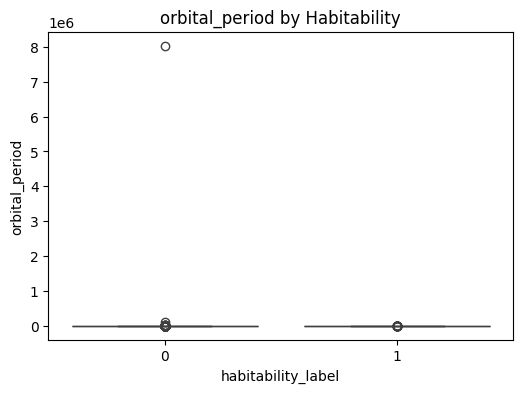

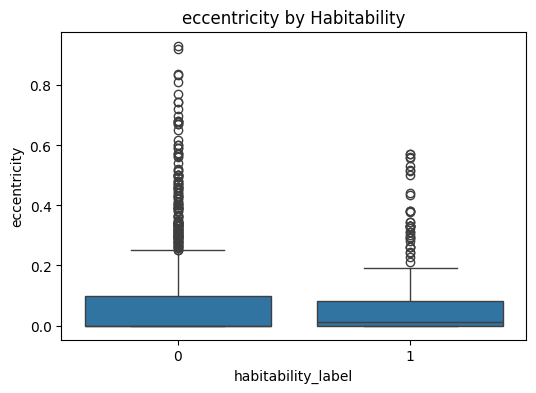

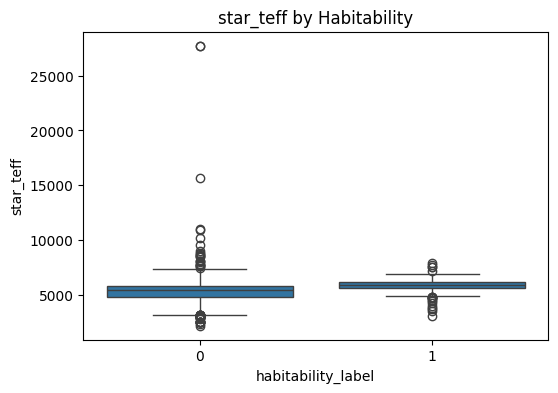

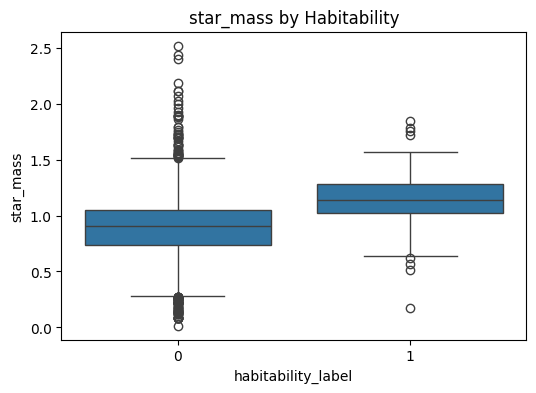

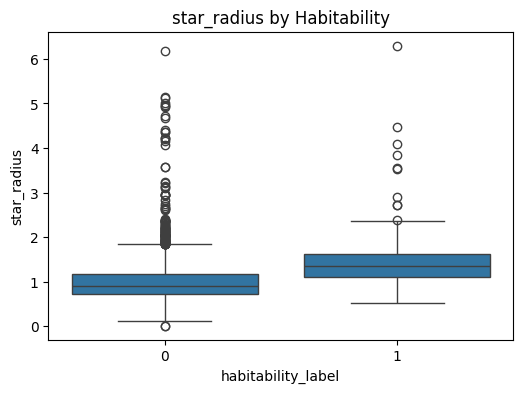

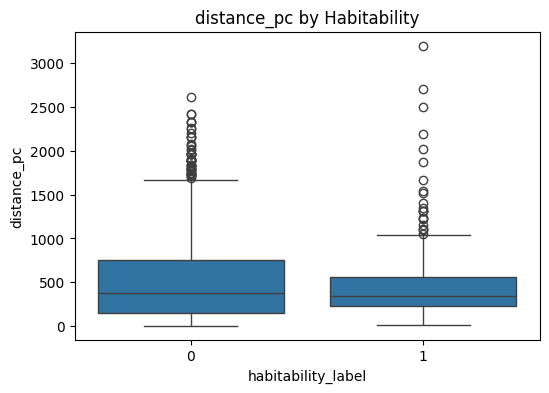

In [8]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='habitability_label', y=col)
    plt.title(f"{col} by Habitability")
    plt.show()

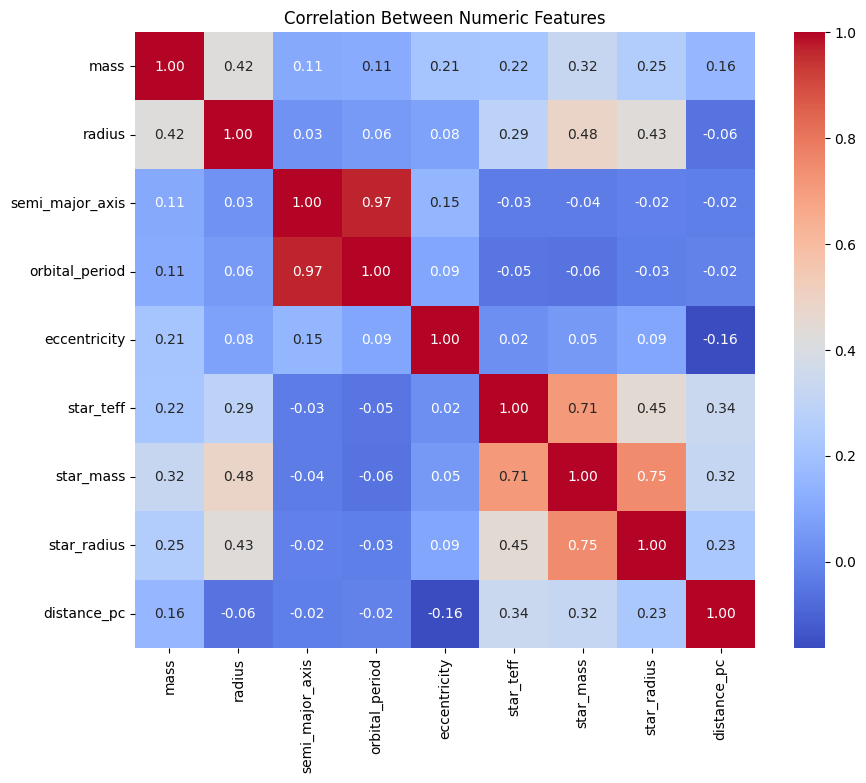

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

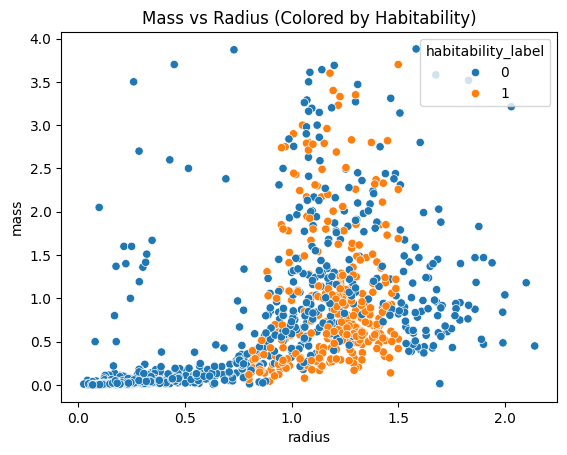

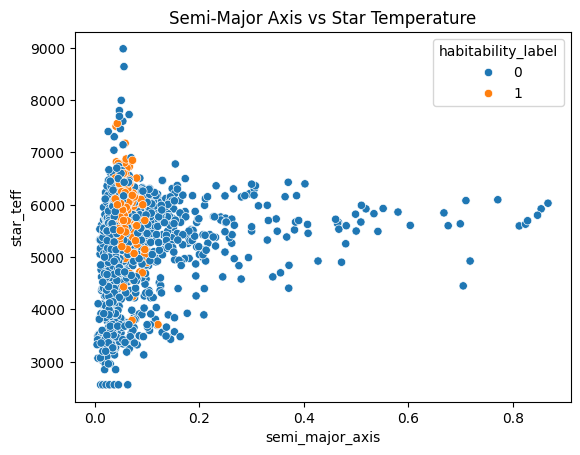

In [10]:
# Mass vs Radius
# Remove extreme values for scatterplot display only
filtered_df = df[
    (df["mass"] < 4) &
    (df["radius"] < 4) &
    (df["semi_major_axis"] < 1) &
    (df["star_teff"] < 10000)  # optional
]


sns.scatterplot(data=filtered_df, x='radius', y='mass', hue='habitability_label')
plt.title("Mass vs Radius (Colored by Habitability)")
plt.show()

# Semi-major axis vs star temperature
sns.scatterplot(data=filtered_df, x='semi_major_axis', y='star_teff', hue='habitability_label')
plt.title("Semi-Major Axis vs Star Temperature")
plt.show()


In [11]:
df.to_csv("../data/clean/exoplanets_tableau_labeled.csv", index=False)
